In [1]:
import os

import numpy as np
import numpy.ma as ma
import numpy.linalg as npl
import pandas as pd

import scipy.signal as signal
import scipy.stats as stats
import scipy.spatial.distance as dist

from statsmodels.tsa import stattools

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

import plotly.express as px

from ipywidgets import interact

# Import data

In [2]:
DATA_DIR = "./data/friends-family/"
USERID = "fa10-01-44"
FEATURE = "CallLog"
EMA = "DailyEMA"

In [3]:
def _get_feature(feature, userid):
    # if userid is not specified, get the file containing all users
    try:
        feature = pd.read_csv(DATA_DIR + f"/{feature}_{userid}.csv", index_col=False)
    except:
        print(f"{feature} file missing for {userid}")
        feature = pd.DataFrame(columns=["timestamp", "userid"])
    
    feature.timestamp = pd.to_datetime(feature.timestamp)
    feature = feature.set_index("timestamp")
    feature = feature.sort_index()
    return feature

In [4]:
call_df = _get_feature(FEATURE, USERID)
ema_df = _get_feature(EMA, USERID)

print("call: ", call_df.shape)
print("ema: ", ema_df.shape)


DailyEMA file missing for fa10-01-44
call:  (3276, 4)
ema:  (0, 1)


# Descriptive analysis and missing data

In [5]:
def index_by_seconds(df):
    df = df.reset_index()
    df["timestamp"] = (df["timestamp"] - df.loc[0, "timestamp"]) // pd.Timedelta("1s")
    return df

In [6]:
def df_index_gaps(df):
    df = df.sort_index()
    df_timestamp = pd.Series(df.index)
    df_gaps = df_timestamp.diff().apply(lambda x: x.total_seconds())
    print("## Data gaps ##")
    print("max: ", df_gaps.max())
    print("min: ", df_gaps.min())
    print("mean: ", df_gaps.mean())
    print("median: ", df_gaps.median())
    print("skew: ", df_gaps.skew())
    return df_gaps

In [7]:
def plot_gaps(df, stop_idx=None):
    gaps_series = df_index_gaps(df)
    gaps_x = np.cumsum(gaps_series)
    gaps_y = gaps_series
    if stop_idx:
        plt.scatter(x=gaps_x[:stop_idx], y=gaps_y[:stop_idx])
    else:
        plt.scatter(x=gaps_x, y=gaps_y)
    

In [8]:
def event_by_weekday(df):
    day_count = df.groupby(df.index.weekday).size()
    day_count.plot(xlabel=["Monday", "Tuesday", "Wednesday", "Thurday", "Friday", "Saturday", "Sunday"], kind="bar")
    return day_count

timestamp
0    482
1    528
2    599
3    424
4    581
5    333
6    329
dtype: int64

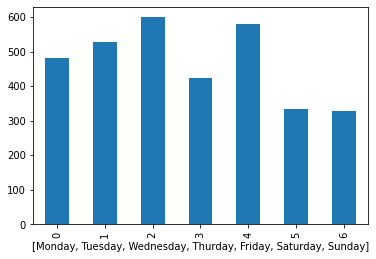

In [9]:
event_by_weekday(call_df)

In [10]:
def event_by_hour(df):
    hour_count = df.groupby(df.index.hour).size()
    hour_count.plot(kind="bar")
    return hour_count

timestamp
0       1
2       4
3       1
4       1
5       1
6       1
7      34
8      94
9     258
10    291
11    362
12    403
13    268
14    251
15    216
16    317
17    275
18    226
19    129
20     75
21     42
22     22
23      4
dtype: int64

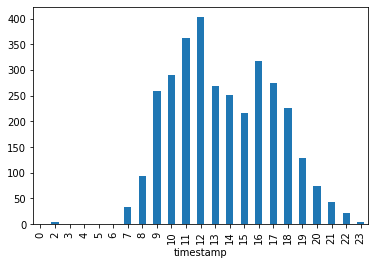

In [11]:
event_by_hour(call_df)

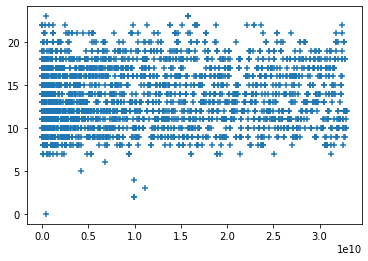

In [12]:
call_df["hour"] = call_df.index.hour
call_df["idx"] = np.cumsum((call_df.index - call_df.index[0]).total_seconds())
plt.scatter(x=call_df["idx"].values, y=call_df["hour"].values, marker="+")

In [13]:
dur_df = call_df[call_df["call_duration"].notna()].copy()

In [14]:
dur_per_day = call_df.groupby(call_df.index.weekday).sum()

In [15]:
dur_df["hour"] = dur_df.index.hour
dur_df["idx"] = np.cumsum((dur_df.index - dur_df.index[0]).total_seconds())

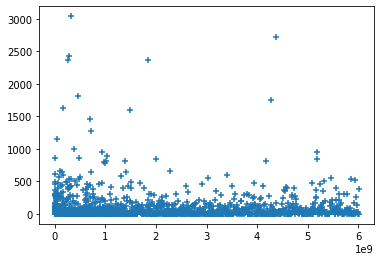

In [16]:
plt.scatter(x=dur_df["idx"].values, y=dur_df["call_duration"].values, marker="+")

<BarContainer object of 1475 artists>

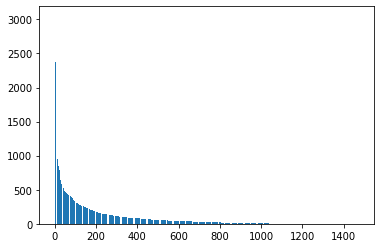

In [17]:
count = dur_df["call_duration"].sort_values(ascending=False).reset_index(drop=True)
plt.bar(x=np.arange(count.shape[0]), height=count)

# Call logs data mining

In [18]:
call_df["call_phone_hash"] = call_df["call_phone_hash"].astype("category").cat.codes #call_df["call_phone_hash"] = call_df["call_phone_hash"].astype("category").cat.codes # convert phone number hash to integer id
call_df = call_df.drop(columns=["userid", "call_duration"]) # drop irrelevant columns
call_df_in = call_df[call_df["call_type"] == "incoming"].drop(columns=["call_type"])
call_df_out = call_df[call_df["call_type"] == "outgoing"].drop(columns=["call_type"])
call_df = call_df.drop(columns=["call_type", "hour", "idx"])

In [19]:
contact_matrix = pd.get_dummies(call_df, columns=["call_phone_hash"])
contact_matrix.shape

(3276, 241)

In [20]:
@interact(n_steps=(1, 3276, 1), curve_zoom=(5, 243, 1), log_scale=False, continuous_update=False)
def plot_contact_curve(n_steps=100, curve_zoom=20, log_scale=False):   
    fig = plt.figure(figsize=(12, 6)) # set size of full figure
    gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 2]) # divide figure into 2 subplot (ax0, ax1)
    fig.tight_layout() # adjust layout spacing
    
    
    ## ax0 data
    ax0 = plt.subplot(gs[0]) # create subplot ax0
    x = np.arange(contact_matrix.shape[1]) # x is the contact id
    y = contact_matrix.iloc[:n_steps, ].sum(axis=0) # y is the number of calls with each contact
    ax0.bar(x, y, align="center", width=0.8) # plot vertical bar chart
    
    ## ax0 format
    plt.grid(True, axis="y")
    ax0.set_xlabel("contact id") # set x label
    ax0.xaxis.set_major_locator(MaxNLocator(integer=True)) # set x tickers to integers
    ax0.set_ylabel("number of calls") # set y label
    if log_scale is True: # parameter to set the y-axis scale to log
        ax0.set_yscale("log")
    else: # if log_scale is False, set y tickers to integers
        ax0.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ## ax1 data
    ax1 = plt.subplot(gs[1]) # create subplot ax1
    curve_y = y.copy().sort_values(ascending=False).values # curve_y is the number of calls per contact in descending order
    ax1.plot(curve_y[:curve_zoom]) # plot curve_y adjusted by the curve_zoom parameter 
    #ax1.bar(np.arange((curve_zoom)), curve_y[:curve_zoom]) # uncomment to plot bar char instead of curve_y
    
    ## ax1 format
    plt.grid(True)
    ax1.set_xlabel("contact rank") # set x label
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # set x tickers to integers
    ax1.set_ylabel("number of calls") # set y label
    if log_scale is True: # parameter to set the y-axis scale to log
        ax1.set_yscale("log")
    else: # if log_scale is False, set y tickers to integers
        ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        
    ## ax2 data
    ax2 = plt.subplot(gs[2])
    y = contact_matrix.iloc[:n_steps, ].sum(axis=0)
    top_contacts = np.flip(np.argsort(y))[:curve_zoom]
    top_values = y[top_contacts]
    ax2_barh = ax2.barh(y=np.arange(len(top_values)), width=np.flip(top_values), align="center")
    
    ## ax2 format
    plt.grid(True, axis="x")
    ax2.set_xlabel("number of calls") # set x label
    if log_scale is True: # parameter to set the x-axis scale to log
        ax2.set_xscale("log")
    else: # if log_scale is False, set x tickers to integers
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        
    ax2.yaxis.set_ticklabels([]) # remove y axis tickers 
    ax2.set_ylabel("contact ranking") # set y label
    if curve_zoom <= 20: # displays the contact id when <= 20 bars are displayed
        plt.bar_label(ax2_barh, labels=np.flip(top_contacts))
        
    plt.show()

interactive(children=(IntSlider(value=100, description='n_steps', max=3276, min=1), IntSlider(value=20, descri…

In [21]:
@interact(n_steps=(1, 3276, 1), curve_zoom=(1, 243, 1), log_scale=False, continuous_update=False)
def plot_contact_curve(n_steps=100, curve_zoom=6, log_scale=False):   
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    fig.tight_layout()    
    
    ## ax0 data
    ax0 = plt.subplot(gs[0])
    y = contact_matrix.iloc[:n_steps, ].sum(axis=0)
    top_contacts = np.flip(np.argsort(y))[:curve_zoom]
    top_values = y[top_contacts]
    ax0_barh = ax0.barh(y=np.arange(len(top_values)), width=np.flip(top_values), align="center")
    
    ## ax0 format
    ax0.yaxis.set_ticklabels([]) # remove y axis tickers 
    if curve_zoom <= 20: # displays the contact id when <= 20 bars are displayed
        plt.bar_label(ax0_barh, labels=np.flip(top_contacts))
        
    if log_scale is True: # parameter to set the x-axis scale to log
        ax0.set_xscale("log")
    else: # if log_scale is False, set x tickers to integers
        ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
        
    
    ## ax1 data
    ax1 = plt.subplot(gs[1])
    cumsum_matrix = np.cumsum(contact_matrix.values, axis=0)
    weighted_step_matrix = cumsum_matrix / cumsum_matrix.sum(axis=1)[:, None]
    curr_top = np.flip(np.argsort(weighted_step_matrix[n_steps]))[:curve_zoom]
    for contact_id in curr_top:
        plt.plot(weighted_step_matrix[1:n_steps, contact_id].T)
        
    ## ax1 format
    ax1.legend(top_contacts)
    if log_scale is True: # parameter to set the x-axis scale to log
        ax1.set_yscale("log")
    else: # if log_scale is False, set x tickers to integers
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

interactive(children=(IntSlider(value=100, description='n_steps', max=3276, min=1), IntSlider(value=6, descrip…

In [22]:
@interact(update_interval=(1, 3276, 1), continuous_update=False)
def plot_contact_curve(update_interval=1):
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 1)#2, width_ratios=[3, 1])
    fig.tight_layout()
    
    ax0 = plt.subplot(gs[0])
    cumsum_matrix = np.cumsum(contact_matrix.values, axis=0)
    y_prob_distances = []
    for i in range(update_interval, contact_matrix.shape[0]):
        y_prob_distances.append(dist.jensenshannon(cumsum_matrix[i], cumsum_matrix[i-update_interval]))
    ax0.plot(y_prob_distances)
    ax0.set_xlabel("number of calls")
    ax0.set_ylabel("Jensen-Shannon divergence / Relative entropy")
    ax0.set_title(f"Probability distribution update every: {update_interval} new calls")

    plt.show()

interactive(children=(IntSlider(value=1, description='update_interval', max=3276, min=1), Output()), _dom_clas…

In [24]:
cumsum_matrix = np.cumsum(contact_matrix.values, axis=0)
rank_matrix = stats.rankdata(cumsum_matrix, method="dense", axis=1) - 1

In [25]:
rankings = np.zeros((cumsum_matrix.shape[0], 6))
for i in range(cumsum_matrix.shape[0]):
    rankings[i, :] = np.flip(np.argsort(cumsum_matrix[i]))[:6]

In [26]:
diff_matrix = np.diff(rankings, axis=0)
binary_matrix = np.where(diff_matrix != 0, 1, 0)

In [33]:
@interact(start_step=(0, 3274, 1), end_step=(1, 3275, 1), log_scale=False, continuous_update=False)
def plot_contact_curve(start_step=0, end_step=730, log_scale=False):
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 1)#2, width_ratios=[3, 1])
    fig.tight_layout()
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(binary_matrix.sum(axis=1)[start_step:end_step])
    #ax0.set_ylim(ax0.get_ylim()[::-1])
    ax0.set_xlabel("number of calls")
    ax0.set_ylabel("number of changes to the top 6 contacts ranking")
    ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax0.yaxis.set_major_locator(MaxNLocator(integer=True))

    #ax0.plot(binary_matrix[start_step:end_step])
    #ax0.legend([1, 2, 3, 4, 5, 6])

    plt.show()

interactive(children=(IntSlider(value=0, description='start_step', max=3274), IntSlider(value=730, description…

# Feature by contact

In [ ]:
call_df = _get_feature(FEATURE, USERID)

In [ ]:
call_df["call_phone_hash"] = call_df["call_phone_hash"].astype("category").cat.codes #call_df["call_phone_hash"] = call_df["call_phone_hash"].astype("category").cat.codes # convert phone number hash to integer id
call_df["call_type"] = call_df["call_type"].replace({"incoming+": "incoming", "outgoing+": "outgoing"})
call_df = call_df.drop(columns=["userid"])

In [ ]:
contact_72 = pd.get_dummies(call_df.loc[call_df["call_phone_hash"] == 72], columns=["call_type", "call_phone_hash"])

In [ ]:
#contact_72 = index_by_seconds(contact_72)
contact_72 = contact_72.reset_index()

In [ ]:
contact_72["call_end"] = contact_72["timestamp"]
contact_72.loc[contact_72["call_end"].isna()] = contact_72["timestamp"] + pd.to_timedelta(np.ones(contact_72.shape[0]), unit="s", errors="coerce")

In [ ]:
fig = px.timeline(data_frame=contact_72, x_start="timestamp", x_end="call_end", y=np.ones(contact_72.shape[0]))
fig.show()

# CallLog and EMA descriptive analysis

In [35]:
def _get_ema(feature, userid):
    ema = _get_feature(feature, userid)
    ema = ema.sort_values("ema_date").drop_duplicates("ema_date", keep="last")
    ema["ema_date"] = pd.to_datetime(ema["ema_date"])
    ema = ema.set_index("ema_date")
    return ema

In [36]:
def fill_missing_datetimeindex(df, freq="d"):
    date_range = pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)
    missing_idx = date_range.difference(df.index)
    print("number of missing index between first and last instances: ", missing_idx.shape[0])
    df = df.append(pd.DataFrame(index=missing_idx))
    return df.sort_index()

In [37]:
ema_df = _get_ema(EMA, "fa10-01-24")
ema_df.shape

(190, 7)

In [38]:
ema_df = fill_missing_datetimeindex(ema_df)

number of missing index between first and last instances:  1


In [39]:
filtered = call_df[ema_df.index.min():ema_df.index.max()]